In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import tarfile
import numpy as np
from urllib import request


base_path = "/content/sample_data/CV__Group_assignment"

if not os.path.isdir(base_path):
  os.makedirs(base_path)

vgg_face_dataset_url = "http://www.robots.ox.ac.uk/~vgg/data/vgg_face/vgg_face_dataset.tar.gz"

with request.urlopen(vgg_face_dataset_url) as r, open(os.path.join(base_path, "vgg_face_dataset.tar.gz"), 'wb') as f:
  f.write(r.read())

with tarfile.open(os.path.join(base_path, "vgg_face_dataset.tar.gz")) as f:
  f.extractall(os.path.join(base_path))

trained_haarcascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"

with request.urlopen(trained_haarcascade_url) as r, open(os.path.join(base_path, "haarcascade_frontalface_default.xml"), 'wb') as f:
    f.write(r.read())


all_subjects = [subject for subject in sorted(os.listdir(os.path.join(base_path, "vgg_face_dataset", "files"))) if subject.startswith("B") and subject.endswith(".txt")]

nb_subjects = 2
nb_images_per_subject = 5

images = []
for subject in all_subjects[:nb_subjects]:

  with open(os.path.join(base_path, "vgg_face_dataset", "files", subject), 'r') as f:
    lines = f.readlines()

  images_ = []
  for line in lines:
    url = line[line.find("http://"): line.find(".jpg") + 4]

    try:
      res = request.urlopen(url)
      img = np.asarray(bytearray(res.read()), dtype="uint8")
      img = cv2.imdecode(img, cv2.IMREAD_COLOR)
      h, w = img.shape[:2]
      images_.append(img)
      # Window name in which image is displayed 
      window_name = 'image'
      # Convert BGR image to RGB
      img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      # Display the image with faces using matplotlib
      plt.imshow(img_rgb)
      plt.axis('off')  # Turn off axis labels
      plt.show()

    except:
      pass

    if len(images_) == nb_images_per_subject:
      images.append(images_)
      break

Found 1 face(s)!


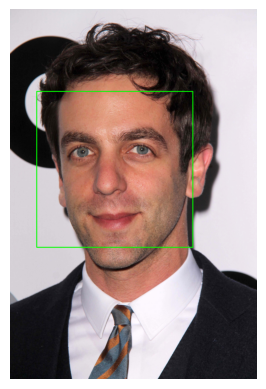

Found 1 face(s)!


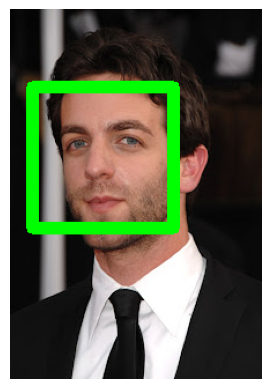

Found 1 face(s)!


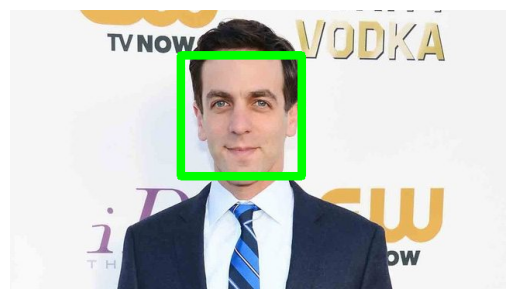

Found 1 face(s)!


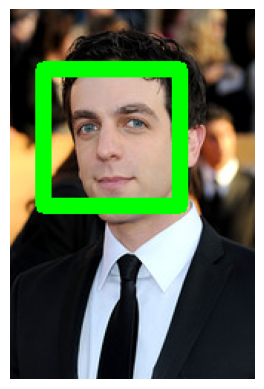

Found 1 face(s)!


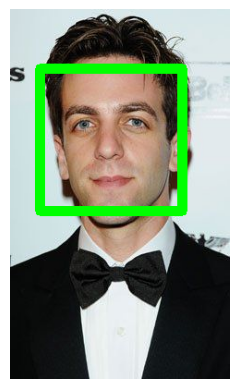

Found 1 face(s)!


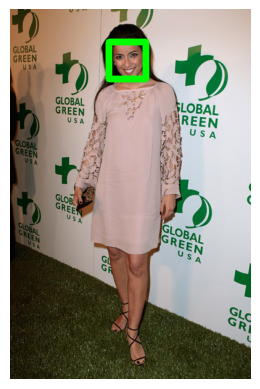

Found 1 face(s)!


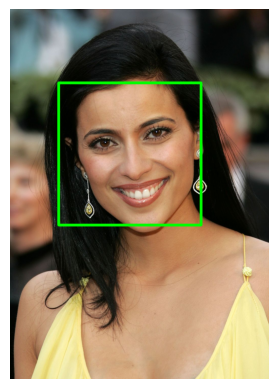

Found 1 face(s)!


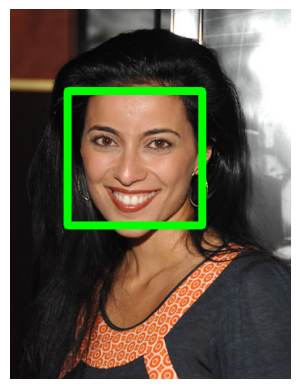

Found 1 face(s)!


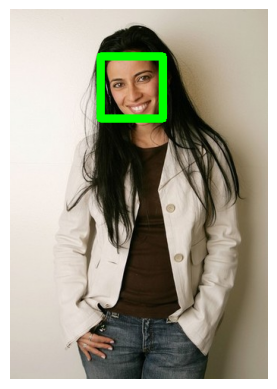

Found 1 face(s)!


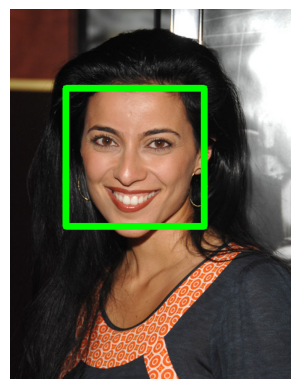

In [5]:
import matplotlib.pyplot as plt

faceCascade = cv2.CascadeClassifier(os.path.join(base_path, "haarcascade_frontalface_default.xml"))

for images_ in images:

  for img in images_:

    img_ = img.copy()
    img_gray = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(
        img_gray,
        scaleFactor=1.2,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    print("Found {} face(s)!".format(len(faces)))

    for (x, y, w, h) in faces:
        cv2.rectangle(img_, (x, y), (x+w, y+h), (0, 255, 0), 10)

    # Convert BGR image to RGB
        img_rgb = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)

        # Display the image with faces using matplotlib
        plt.imshow(img_rgb)
        plt.axis('off')  # Turn off axis labels
        plt.show()